In [1]:
import numpy as np, pandas as pd, scipy.stats as ss, seaborn as sns, os
from matplotlib import pyplot as plt
%matplotlib inline
np.random.seed(71191)

def allelic_ANOVA(site, pheno):
    """
    This regression is equivalent to one-way ANOVA with 2 groups. 
    Return F-statistic.
    Assumes site is coded as -1, 1
    """
    coding = np.array(site, np.float)
    pheno = np.array(pheno, np.float)
    
    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    # coefficient of determination is R**2
    #R = len_yhat/len_y
    
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F


def association_logPval(site, pheno):
    F = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP

In [2]:
gv = pd.read_csv('./CDx-ill-SNP-INDEL-df-104-blocked.csv.gz')
print(gv.shape)
gv.head()
loci = gv.Block.drop_duplicates().index

(92103, 125)


In [3]:
paul = pd.read_csv('/home/croth/Downloads/melanin_measurements_paul.csv')
paul = paul[(paul.strain!='H99')&(paul.replicate==1 )]
paul['plate'] = [int(a[-1]) for a in paul.plate]

In [4]:
data = pd.read_csv('/home/croth/Downloads/osmotic-stress-Jun262019.csv')
data = data[(data.strain!='H99')]
data.drop(['Date','label','media','strain','type'],axis=1,inplace=True)
data['plate'] = [abs(int(a[-1])-3) for a in data.plate]
#data['plate'] = [int(a[-1]) for a in data.plate]
data['rep'] = [a[-1] for a in data.rep]
data['rep'].replace(dict(zip(['a','b','c'],[0,1,2])),
                    inplace=True)
data = data.merge(paul[['row','column','plate','strain']])
data['NaCl'] = [float(a[:-1]) for a in data.NaCl]

In [5]:
chrom_colors = ['tab:grey','tab:brown','lightgrey','salmon','tan']

In [6]:
data['mean_intensity'] = data['mean_intensity'].fillna(56000.0)

In [7]:
paul[(paul.strain.isin(
    ['XL280a','XL280alpha','SS-A837']))][['row','column','plate','strain']].drop_duplicates()

,row,column,plate,strain
153,e,5,2,XL280alpha
154,e,6,2,XL280a
155,e,7,2,SS-A837


In [8]:
paul[(paul.strain=='SS-A837')]

,row,column,plate,strain,replicate,day,mean_grey,background_grey,melanin_binary
155,e,7,2,SS-A837,1,3,62.436,110.928,1.0


In [9]:
data[(data.NaCl==1)].rep.unique()

array([0, 1, 2])

In [10]:
osmorep = data.groupby(['NaCl','strain','rep']).agg(np.nanmean)
osmorep.reset_index(inplace=True)
osmo = osmorep.groupby(['NaCl','strain']).agg(np.nanmean)
osmo.reset_index(inplace=True)

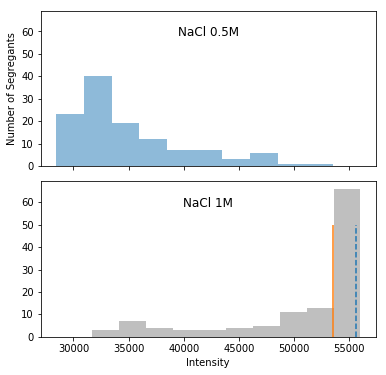

In [11]:
fig,ax = plt.subplots(2,1,figsize=(6,6),
                      sharex=True,sharey=True)
plt.sca(ax[0])
plt.hist(osmo[(osmo.NaCl==0.5)]['mean_intensity'],alpha=0.5);
plt.title('NaCl 0.5M',x=0.5,y=0.8);
plt.ylabel('Number of Segregants')
plt.sca(ax[1])
plt.title('NaCl 1M',x=0.5,y=0.8)
plt.hist(osmo[(osmo.NaCl==1)]['mean_intensity'],color='grey',alpha=0.5);
plt.vlines(osmo[(osmo.NaCl==1.0) & 
                (osmo.strain=='SS-A837')]['mean_intensity'],
           0,50,linestyles='-',color='tab:orange')
plt.vlines(osmo[(osmo.NaCl==1.0) & 
                (osmo.strain=='XL280a')]['mean_intensity'],
           0,50,linestyles='--',color='tab:blue')

plt.xlabel('Intensity');
plt.subplots_adjust(hspace=0.1);

In [12]:
segs = np.array([s 
                 for s in osmo.strain.unique() 
                 if s in gv.columns])
len(segs)

104

In [13]:
osmo.index = osmo.strain

In [14]:
pheno = osmo[(osmo.NaCl==1)]

In [15]:
test = gv[segs].drop_duplicates()

test['1M'] = test.apply(association_logPval,args=[pheno.T[segs].T['mean_intensity']],axis=1)

pval_df = gv.merge(test)

In [16]:
pval_df.head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B565,SS-B600,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382,1M
0,Chr01,5016,104492.0,1.0,C,A,1,6510,snp,289,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.066362
1,Chr01,5299,112647.0,1.0,T,C,1,9711,snp,293,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.066362
2,Chr01,5464,112658.0,1.0,T,C,1,9375,snp,294,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.066362
3,Chr01,6120,109003.0,1.0,T,C,1,9311,snp,311,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.066362
4,Chr01,6166,114638.0,1.0,G,A,1,9269,snp,312,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.066362


In [17]:
pval_df.to_csv('./Cdx_osmotic_1M_pvalues.csv',index=True)

In [18]:
chrlist = sorted(pval_df.Chrom.unique())
chrlens = np.array([pval_df[(pval_df.Chrom==c)].Pos.max() 
           for c in chrlist])
cumpos = np.array([0] + list(np.cumsum(chrlens[:-1])))
cummax = cumpos[-1] + pval_df[(pval_df.Chrom=='Chr14')].Pos.max()
chrmid = (chrlens/2) + cumpos

In [19]:
from PIL import Image

In [20]:
from matplotlib import rc

In [21]:
plt.style.use(['tableau-colorblind10'])

In [22]:
perms = pd.read_csv('./Cdx_osmo_NaCl_1M_perms_10000.csv',index_col=0)

In [23]:
alpha005 = np.percentile(perms.Pval.values,95)

In [24]:
alpha001 = np.percentile(perms.Pval.values,99)

In [25]:
qtl10_ix = pval_df[(pval_df['1M']>alpha005) & (pval_df.Chrom=='Chr10')].index
qtl10_block = gv.T[qtl10_ix].T['Block']
qtl10_gv = gv[(gv.Block.isin(qtl10_block))]
qtl10_bounds = (qtl10_gv.Pos.min(),qtl10_gv.Pos.max())
print(qtl10_bounds)
print(np.diff(qtl10_bounds)[0])

(952008, 995555)
43547


In [26]:
qtl10_ix = pval_df[(pval_df.Chrom=='Chr10')]['1M'].idxmax()
pxg = osmo[(osmo.NaCl==1)][['mean_intensity']].copy()
pxg['qtl10'] = gv.T[qtl10_ix][pheno.index]
pxg['qtl10'] = pxg.qtl10.apply(float)
pxg.dropna(inplace=True)
pxg.shape

(104, 2)

In [27]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='mean_intensity~qtl10', data=pxg)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         mean_intensity   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     22.22
Date:                Tue, 05 May 2020   Prob (F-statistic):           7.72e-06
Time:                        17:26:04   Log-Likelihood:                -1054.0
No. Observations:                 104   AIC:                             2112.
Df Residuals:                     102   BIC:                             2117.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.831e+04    815.715     59.224      0.000    4.67e+04    4.99e+04
qtl10       5719.8047   1213.405      4.714      0.000    3313.021    8126.589
==============================================================================
Omnibus:                       12.559   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.821
Skew:                          -0.888   Prob(JB):                     0.000997
Kurtosis:                       3.186   Cond. No.                         2.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

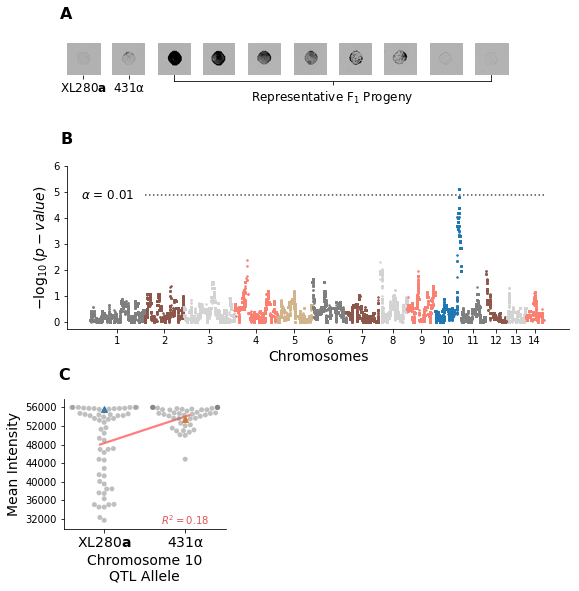

In [28]:
fig,ax = plt.subplots(1,1,figsize=(9,3),sharex=True,sharey=True)

for c in chrlist:
    i = int(c[3:])-1
    
    if c == 'Chr10':
        cc = 'tab:blue'
    else:
        cc = chrom_colors[i%len(chrom_colors)]
    temp = pval_df[(pval_df.Chrom==c)]
    plt.plot(temp.Pos.values+cumpos[i],temp['1M'].values,'.',color=cc,ms=3);
    
plt.xticks(chrmid,np.arange(len(chrlist))+1);
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);
plt.xlabel('Chromosomes',fontsize=14);
plt.hlines(alpha001,chrlens[0],19*(10**6),color='k',alpha=0.7,
           linestyles='dotted')


plt.yticks(np.arange(7))
[ax.spines[s].set_visible(False) for s in ['top','right']]

#plt.hlines(alpha005,chrlens[0],19*(10**6),color='k',alpha=0.7,
#           linestyles='dashed')

plt.title('B',x=0,y=1.1,fontweight='bold',fontsize=16)
#plt.legend(bbox_to_anchor=(.3,1),frameon=True,fontsize=12)
plt.text(s = r'$\alpha$ = 0.01', x = (2/3)*chrmid[0],y= alpha001,
         horizontalalignment='center',
         verticalalignment='center', fontsize=12)
         #transform=ax.transAxes, fontsize=14 )

#plt.text(s = r'$\alpha$ = 0.05', x = 0.08,y= .775, 
#         horizontalalignment='center',
#         verticalalignment='center', 
#         transform=ax.transAxes, fontsize=14 )

plt.sca(ax)
axs = fig.add_axes([0.29,1.27,.49,.1])
plt.xticks([0.5],labels=['Representative F$_{1}$ Progeny'],fontsize=12)
plt.yticks([ ],labels=None)
axs.spines['top'].set_visible(False) 


## Plot xl280a
plt.sca(ax)
axm = fig.add_axes([0.1,1.3,0.1,.15])
xl280a_path = '/home/croth/Downloads/osmo_crop_segs/xl280a.png'
xl280a_obj = Image.open(xl280a_path)
plt.imshow(xl280a_obj),# aspect='auto')
plt.xticks([np.array(xl280a_obj).shape[0]/2],labels=['XL280'+ r'$\bf{a}$'],fontsize=12)
plt.yticks([]);
plt.title('A',fontsize=16,fontweight='bold',x=0,y=1.54);
[axm.spines[a].set_visible(False) for a in ['top','bottom','left','right']]

## Plot 431
plt.sca(ax)
axm = fig.add_axes([0.17,1.3,0.1,.15])
plt.yticks([]);
A837_path = '/home/croth/Downloads/osmo_crop_segs/431alpha.png'
A837_obj = Image.open(A837_path)
plt.imshow(A837_obj),# aspect='auto')
plt.xticks([np.array(A837_obj).shape[0]/2],labels=['431'+'$\mathrm{\u03B1}$'],fontsize=12)
[axm.spines[a].set_visible(False) for a in ['top','bottom','left','right']]


plt.sca(ax)
## Plot S1
axm = fig.add_axes([0.24,1.3,0.1,.15])
plt.yticks([]);
spath = '/home/croth/Downloads/osmo_crop_segs/d11.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax)
## Plot S1
axm = fig.add_axes([0.31,1.3,0.1,.15])
plt.yticks([]);
spath = '/home/croth/Downloads/osmo_crop_segs/c4.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax)
## Plot S1
axm = fig.add_axes([0.38,1.3,0.1,.15])
plt.yticks([]);
spath = '/home/croth/Downloads/osmo_crop_segs/f3.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax)
## Plot S4
axm = fig.add_axes([0.45,1.3,0.1,.15])
plt.yticks([]);
spath = '/home/croth/Downloads/osmo_crop_segs/d10.png' 
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax)
## Plot S4
axm = fig.add_axes([0.52,1.3,0.1,.15])
plt.yticks([]);
spath = '/home/croth/Downloads/osmo_crop_segs/b5.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax)
## Plot S4
axm = fig.add_axes([0.59,1.3,0.1,.15])
plt.yticks([]);
spath = '/home/croth/Downloads/osmo_crop_segs/f5.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')

plt.sca(ax)
## Plot S4
axm = fig.add_axes([0.66,1.3,0.1,.15])
plt.yticks([]);
spath = '/home/croth/Downloads/osmo_crop_segs/d4.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')

plt.sca(ax)
## Plot S4
axm = fig.add_axes([0.73,1.3,0.1,.15])
plt.yticks([]);
spath = '/home/croth/Downloads/osmo_crop_segs/e3.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')

axr = fig.add_axes([0.12,-.8,0.25,0.6])
sns.regplot(x='qtl10',y='mean_intensity',ci=False,
           data=pxg,scatter_kws={'alpha':0.0},
            line_kws={'color':'red','alpha':0.5})
sns.swarmplot(x='qtl10',y='mean_intensity',
              data=pxg,color='grey',alpha=0.5);
plt.plot(*pxg.T['XL280a'].T[['qtl10','mean_intensity']].values,
         '^',color='tab:blue')
plt.plot(*pxg.T['SS-A837'].T[['qtl10','mean_intensity']].values,
         '^',color='tab:orange')
plt.title('C',fontsize=16,fontweight='bold',x=0,y=1.1)
plt.ylabel('Mean Intensity',fontsize=14);
plt.xlabel('Chromosome 10\nQTL Allele',fontsize=14)
plt.xticks([0,1],['XL280'+ r'$\bf{a}$',
                  '431'+'$\mathrm{\u03B1}$'],fontsize=14)
plt.text(y= pxg.mean_intensity.min() ,
         x= np.abs(pxg.T[pxg.mean_intensity.idxmin()].T['qtl10'] - 1) ,
         s='$R^2 = %s$'%(np.round(res.rsquared,2)),
         va='center',ha='center',color='tab:red',alpha=0.8)
plt.yticks(np.arange(pxg.mean_intensity.max(),pxg.mean_intensity.min(),-4000))
[axr.spines[s].set_visible(False) for s in ['top','right']]

plt.savefig('./NaCl_1_M_mean_intensity_Manhattan.png',
            dpi=150,bbox_inches='tight');

In [29]:
pwd

'/home/croth'

In [30]:
pheno.to_csv('./Cdx_osmo_NaCl_1M.csv',index=False);

In [31]:
#assert 1 == 0

fig,ax = plt.subplots(1,1,figsize=(9,3),sharex=True,sharey=True)

for c in chrlist[::-1]:
    i = int(c[3:])-1
    temp = pval_df[(pval_df.Chrom==c)]
    plt.plot(temp.Pos.values+cumpos[i],temp['1M'].values,'.');
plt.xticks(chrmid,np.arange(len(chrlist))+1);
plt.ylabel("$-log_{10}(p-value)$",fontsize=14);
plt.xlabel('Chromosomes',fontsize=14);
plt.hlines(alpha001,chrlens[0],19*(10**6),color='k',alpha=0.7,
           linestyles='dotted')
plt.hlines(alpha005,chrlens[0],19*(10**6),color='k',alpha=0.7,
           linestyles='dashed')

plt.title('B',x=0,y=1.1,fontweight='bold',fontsize=16)
#plt.legend(bbox_to_anchor=(.3,1),frameon=True,fontsize=12)
plt.text(s = r'$\alpha$ = 0.01', x = 0.08,y= .91, 
         horizontalalignment='center',
         verticalalignment='center', 
         transform=ax.transAxes, fontsize=14 )

plt.text(s = r'$\alpha$ = 0.05', x = 0.08,y= .775, 
         horizontalalignment='center',
         verticalalignment='center', 
         transform=ax.transAxes, fontsize=14 )

plt.sca(ax)
axs = fig.add_axes([0.29,1.27,.49,.1])
plt.xticks([0.5],labels=['Representative F$_{1}$ Progeny'],fontsize=12)
plt.yticks([ ],labels=None)
axs.spines['top'].set_visible(False) 


## Plot xl280a
plt.sca(ax)
axm = fig.add_axes([0.1,1.3,0.1,.15])
xl280a_path = '/home/croth/Downloads/osmo_crop_segs/xl280a.png'
xl280a_obj = Image.open(xl280a_path)
plt.imshow(xl280a_obj),# aspect='auto')
plt.xticks([np.array(xl280a_obj).shape[0]/2],labels=['XL280'+ r'$\bf{a}$'],fontsize=12)
plt.yticks([]);
plt.title('A',fontsize=16,fontweight='bold',x=0,y=1.54);
[axm.spines[a].set_visible(False) for a in ['top','bottom','left','right']]

## Plot 431
plt.sca(ax)
axm = fig.add_axes([0.17,1.3,0.1,.15])
plt.yticks([]);
A837_path = '/home/croth/Downloads/osmo_crop_segs/431alpha.png'
A837_obj = Image.open(A837_path)
plt.imshow(A837_obj),# aspect='auto')
plt.xticks([np.array(A837_obj).shape[0]/2],labels=['431'+'$\mathrm{\u03B1}$'],fontsize=12)
[axm.spines[a].set_visible(False) for a in ['top','bottom','left','right']]


plt.sca(ax)
## Plot S1
axm = fig.add_axes([0.24,1.3,0.1,.15])
plt.yticks([]);
spath = '/home/croth/Downloads/osmo_crop_segs/d11.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax)
## Plot S1
axm = fig.add_axes([0.31,1.3,0.1,.15])
plt.yticks([]);
spath = '/home/croth/Downloads/osmo_crop_segs/c4.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax)
## Plot S1
axm = fig.add_axes([0.38,1.3,0.1,.15])
plt.yticks([]);
spath = '/home/croth/Downloads/osmo_crop_segs/f3.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax)
## Plot S4
axm = fig.add_axes([0.45,1.3,0.1,.15])
plt.yticks([]);
spath = '/home/croth/Downloads/osmo_crop_segs/d10.png' 
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax)
## Plot S4
axm = fig.add_axes([0.52,1.3,0.1,.15])
plt.yticks([]);
spath = '/home/croth/Downloads/osmo_crop_segs/b5.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax)
## Plot S4
axm = fig.add_axes([0.59,1.3,0.1,.15])
plt.yticks([]);
spath = '/home/croth/Downloads/osmo_crop_segs/f5.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')

plt.sca(ax)
## Plot S4
axm = fig.add_axes([0.66,1.3,0.1,.15])
plt.yticks([]);
spath = '/home/croth/Downloads/osmo_crop_segs/d4.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')

plt.sca(ax)
## Plot S4
axm = fig.add_axes([0.73,1.3,0.1,.15])
plt.yticks([]);
spath = '/home/croth/Downloads/osmo_crop_segs/e3.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')

axr = fig.add_axes([1.03,0.13,0.25,0.75])
sns.regplot(x='qtl10',y='mean_intensity',ci=False,
           data=pxg,scatter_kws={'alpha':0.0},
            line_kws={'color':'red','alpha':0.5})
sns.swarmplot(x='qtl10',y='mean_intensity',
              data=pxg,color='grey',alpha=0.5);
plt.plot(*pxg.T['XL280a'].T[['qtl10','mean_intensity']].values,
         '^',color='tab:blue')
plt.plot(*pxg.T['SS-A837'].T[['qtl10','mean_intensity']].values,
         '^',color='tab:orange')
plt.title('C',fontsize=16,fontweight='bold',x=0,y=1.1)
plt.ylabel('Mean Intensity',fontsize=14);
plt.xlabel('Chromosome 10\nQTL Allele',fontsize=14)
plt.xticks([0,1],['XL280'+ r'$\bf{a}$',
                  '431'+'$\mathrm{\u03B1}$'],fontsize=14)
plt.text(x=0.5,y=32500,s='$R^2 = %s$'%(np.round(res.rsquared,2)),
         va='center',ha='center',color='tab:red',alpha=0.8)

#plt.savefig('./NaCl_1_M_mean_intensity_Manhattan.png',
#            dpi=150,bbox_inches='tight');

perms = pd.read_csv('/home/croth/Cdx_assigned_permutations.csv')
perms.shape

file = open('./Cdx_osmo_NaCl_1M_perms_10000.csv','w+')
file.writelines('Perm,Pval\n')
file.close()

for i, p in perms.iterrows():
    osmo_p = osmo[(osmo.NaCl==1)& (osmo.strain.isin(segs))].copy()
    osmo_p.index = p
    pvalmax = np.max(gv.T[loci].T[osmo_p.index].apply(
                association_logPval,
                args=[
            osmo_p.T[osmo_p.index].T['mean_intensity']],
            axis=1))
    osmo_perms = open('./Cdx_osmo_NaCl_1M_perms_10000.csv','a')
    osmo_perms.writelines('%s,%s\n'%(i,pvalmax))
    osmo_perms.close()

In [32]:
gff3 = pd.read_csv('/home/croth/Downloads/xl280genome.gff3.csv.gz',index_col=0)
genes = pd.read_csv('/home/croth/Downloads/XL280_431_gene_analysis.csv.gz')

In [33]:
qtl10_gene = gff3[(gff3.contig=='Chr10') & 
                    (gff3.start>=qtl10_bounds[0]) & 
                    (gff3.end<=qtl10_bounds[-1])].sort_values('gene').gene.unique()

In [52]:
qtl10_gene_pos = gff3[(gff3.gene.isin(qtl10_gene)) & 
                     (gff3.type=='gene')
                    ][['gene','start','end','strand','description']]

qtl10_gene_pos['description'] = [' '.join(a.split('%2C')) for a in qtl10_gene_pos.description]

In [53]:
osmo_genes = genes[(genes.gene.isin(qtl10_gene))].merge(qtl10_gene_pos).sort_values('gene')
aach = []
for i,j in osmo_genes[['nonsense','missense']].iterrows():
    if j.nonsense == 1:
        aach.append('SG')
    elif j.nonsense == 2:
        aach.append('SL')
    else:
        aach.append(j.missense)
osmo_genes['Amino Acid Changes'] = aach
osmo_genes.drop(['mod_three','length_check','chrom','nonsense','missense'],
                axis=1,inplace=True)

In [54]:
osmo_genes.shape

(18, 6)

In [55]:
osmo_genes.columns = [a.capitalize() for a in osmo_genes.columns]

In [56]:
osmo_genes['Position (bp)'] = [':'.join(j[['Start','End']].apply(str).tolist())
                               for i,j in osmo_genes.iterrows()]

In [59]:
osmo_genes = osmo_genes[['Gene','Position (bp)','Strand','Description','Amino acid changes']]

In [69]:
osmo_genes.columns = osmo_genes.columns.tolist()[:-1] + ['Amino Acid Change']

In [70]:
osmo_genes.head()

,Gene,Position (bp),Strand,Description,Amino Acid Change
4,CNJ03080,951565:954309,+,FZC1,2
15,CNJ03090,954270:960232,-,Glycogen debranching enzyme putative,3
3,CNJ03095,960455:961826,-,unspecified product,4
13,CNJ03100,963197:964902,-,expressed protein,SL
0,CNJ03110,966388:967236,-,ribosomal protein S18 putative,0


In [71]:
osmo_genes.loc[4,'Description'] = 'FZC1'

/home/croth/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/croth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
osmo_genes

,Gene,Position (bp),Strand,Description,Amino Acid Change
4,CNJ03080,951565:954309,+,FZC1,2
15,CNJ03090,954270:960232,-,Glycogen debranching enzyme putative,3
3,CNJ03095,960455:961826,-,unspecified product,4
13,CNJ03100,963197:964902,-,expressed protein,SL
0,CNJ03110,966388:967236,-,ribosomal protein S18 putative,0
17,CNJ03120,967502:968477,+,hypothetical protein,0
8,CNJ03130,972777:974801,+,expressed protein,0
12,CNJ03140,975305:976851,+,expressed protein,1
1,CNJ03150,976834:978271,-,expressed protein,5
11,CNJ03153,978272:979647,-,unspecified product,3


In [73]:
osmo_genes.to_csv('./Osmo_QTL_genes.csv',index=False)